# CIFAR-10 Image Classification with Vision Transformer and CNN

###a.

In [ ]:
#load the meta of the dataset from google drive

from google.colab import drive
drive.mount('/content/drive')

import pickle

# Replace with the actual path to your dataset in Google Drive
path = '/content/drive/My Drive/cifar-10-batches-py/batches.meta'

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

data = unpickle(path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Print the keys in the dictionary
print("Keys in the dataset:", data.keys())

# Inspect values for each key
for key in data.keys():
    print(f"\nKey: {key}")
    print(f"Value: {data[key]}")

# Check label names
if b'label_names' in data:
    label_names = data[b'label_names']
    print("\nLabel names:")
    for i, label in enumerate(label_names):
        print(f"{i}: {label.decode('utf-8')}")

Keys in the dataset: dict_keys([b'num_cases_per_batch', b'label_names', b'num_vis'])

Key: b'num_cases_per_batch'
Value: 10000

Key: b'label_names'
Value: [b'airplane', b'automobile', b'bird', b'cat', b'deer', b'dog', b'frog', b'horse', b'ship', b'truck']

Key: b'num_vis'
Value: 3072

Label names:
0: airplane
1: automobile
2: bird
3: cat
4: deer
5: dog
6: frog
7: horse
8: ship
9: truck


In [ ]:
# Load the actual dataset from Google Drive
# I will be using only one batch for computational reasons
path = '/content/drive/My Drive/cifar-10-batches-py/data_batch_1'

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

batch_1 = unpickle(path)

In [ ]:
#Print the keys in the dictionary
print("Keys in the dataset:", batch_1.keys())

# Inspect values for each key
for key in batch_1.keys():
    print(f"\nKey: {key}")
    print(f"Value: {batch_1[key][:10]}")

# Check label names
if b'label_names' in batch_1:
    label_names = batch_1[b'label_names'][:10]
    print("\nLabel names:")
    for i, label in enumerate(label_names[:10]):
        print(f"{i}: {label.decode('utf-8')}")


Keys in the dataset: dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

Key: b'batch_label'
Value: b'training b'

Key: b'labels'
Value: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3]

Key: b'data'
Value: [[ 59  43  50 ... 140  84  72]
 [154 126 105 ... 139 142 144]
 [255 253 253 ...  83  83  84]
 ...
 [ 28  30  33 ... 100  99  96]
 [134 131 128 ... 136 137 138]
 [125 110 102 ...  82  84  86]]

Key: b'filenames'
Value: [b'leptodactylus_pentadactylus_s_000004.png', b'camion_s_000148.png', b'tipper_truck_s_001250.png', b'american_elk_s_001521.png', b'station_wagon_s_000293.png', b'coupe_s_001735.png', b'cassowary_s_001300.png', b'cow_pony_s_001168.png', b'sea_boat_s_001584.png', b'tabby_s_001355.png']


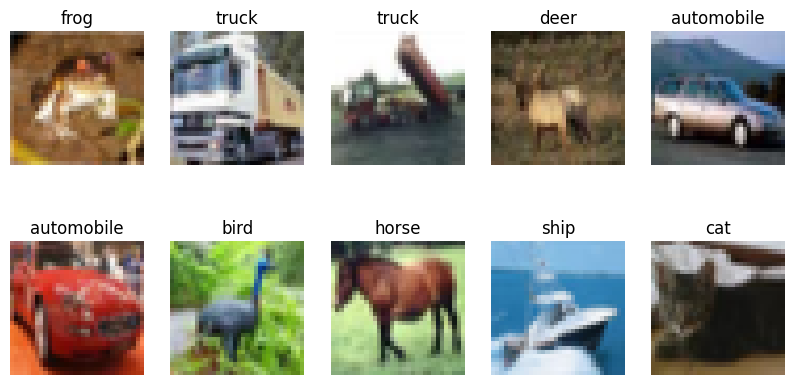

In [ ]:
#plot some pics

import matplotlib.pyplot as plt
import numpy as np

# Extract images and labels
images = batch_1[b'data']
labels = batch_1[b'labels']

# Reshape images to 32x32x3
images = images.reshape((len(images), 3, 32, 32)).transpose(0, 2, 3, 1)

# Plot some images
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i])
    plt.title(label_names[labels[i]].decode('utf-8'))
    plt.axis('off')
plt.show()



###b.

In [ ]:
from transformers import AutoImageProcessor, AutoModelForImageClassification

# Load the processor and model with a classification head
processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
model_hg = AutoModelForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=len(set(labels))
)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream ta

In [ ]:
import torch
import torchvision.transforms as transforms

# Define the transformation
transform = transforms.Compose([
    transforms.ToPILImage(),   # Convert the NumPy array to a PIL Image
    transforms.Resize((224, 224)),  # Resize the image to 224x224
    transforms.ToTensor(),     # Convert the image to a tensor and normalize to [0, 1]
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))  # Normalize with mean and std
])

# Apply the transformation to the entire batch
images_rescaled = torch.stack([transform(image) for image in images])

# Convert labels to tensors
labels = torch.tensor(labels)


In [ ]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move the model to the GPU
model_hg.to(device)

# Move images and labels to GPU during training
images_rescaled = images_rescaled.to(device)
labels = labels.to(device)


Using device: cuda


In [ ]:
from sklearn.model_selection import train_test_split

# Split into train, val, and test sets
train_images, temp_images, train_labels, temp_labels = train_test_split(
    images_rescaled, labels, test_size=0.3, random_state=42  # 30% will be split into val and test
)
val_images, test_images, val_labels, test_labels = train_test_split(
    temp_images, temp_labels, test_size=0.5, random_state=42  # 15% each for val and test
)


In [ ]:
from torch.utils.data import TensorDataset, DataLoader

# Create DataLoader for train, val, and test datasets
train_dataset = TensorDataset(train_images, train_labels)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(val_images, val_labels)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

test_dataset = TensorDataset(test_images, test_labels)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
# Validation loop
model_hg.eval()  # Set the model to evaluation mode
val_loss = 0
correct = 0
with torch.no_grad():  # No need to calculate gradients during validation
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_hg(images)
        loss = torch.nn.functional.cross_entropy(outputs.logits, labels)
        val_loss += loss.item()
        pred = outputs.logits.argmax(dim=1, keepdim=True)
        correct += pred.eq(labels.view_as(pred)).sum().item()

# Calculating val. loss and accuracy
val_loss /= len(val_loader.dataset)
val_accuracy = 100. * correct / len(val_loader.dataset)

print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    val_loss, correct, len(val_loader.dataset), val_accuracy))



Validation set: Average loss: 0.0717, Accuracy: 228/1500 (15%)



###c.

In [ ]:
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from tqdm import tqdm

# Fine-tuning the huggingface model
# Define the optimizer and loss function
optimizer = Adam(model_hg.parameters(), lr=1e-4)
loss_fn = CrossEntropyLoss()

# Training loop
model_hg.train()
for epoch in range(5):
    total_loss = 0
    for batch in tqdm(train_loader):
        batch_images, batch_labels = batch

        optimizer.zero_grad()
        outputs = model_hg(batch_images)

        logits = outputs.logits
        loss = loss_fn(logits, batch_labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader)}")


100%|██████████| 219/219 [01:36<00:00,  2.27it/s]


Epoch 1, Loss: 0.5761733013609228


100%|██████████| 219/219 [01:39<00:00,  2.21it/s]


Epoch 2, Loss: 0.12368799419435736


100%|██████████| 219/219 [01:40<00:00,  2.18it/s]


Epoch 3, Loss: 0.07148051334196302


100%|██████████| 219/219 [01:40<00:00,  2.18it/s]


Epoch 4, Loss: 0.04823987467903389


100%|██████████| 219/219 [01:40<00:00,  2.17it/s]

Epoch 5, Loss: 0.056241576768219746


In [ ]:
# Evaluation loop
model_hg.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for val_images, val_labels in val_loader:
        val_images, val_labels = val_images.to(device), val_labels.to(device)

        outputs = model_hg(val_images)
        _, predicted = torch.max(outputs.logits, 1)

        y_true.extend(val_labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

from sklearn.metrics import classification_report, accuracy_score
print("Validation Accuracy:", accuracy_score(y_true, y_pred) * 100)


Validation Accuracy: 96.46666666666667


###d.

In [ ]:
from tensorflow.keras.utils import to_categorical

# Preparing the dataset for CNN model
# Extract images and labels
images = batch_1[b'data']
labels = batch_1[b'labels']

# Reshape images to 32x32x3
images = images.reshape((len(images), 3, 32, 32)).transpose(0, 2, 3, 1)

#Normalize images to the range [0, 1]
images = images.astype('float32') / 255.0

# One-hot encode labels for categorical crossentropy
num_classes = 10
labels = to_categorical(labels, num_classes)

# Split into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(
    images, labels, test_size=0.2, random_state=42  # 20% for validation
)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
import tensorflow as tf

# Build the model
model_cnn = Sequential([
    Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', input_shape=(32, 32, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Flatten(),

    Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.4),
    Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.4),

    Dense(10, activation='softmax')
])

model_cnn.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))

# training the model for 50 epochs
model_cnn.fit(X_train, Y_train, batch_size=128, epochs=100, validation_data=(X_test, Y_test))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 208ms/step - accuracy: 0.1309 - loss: 4.7396 - val_accuracy: 0.1045 - val_loss: 3.9421
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2064 - loss: 3.4998 - val_accuracy: 0.1095 - val_loss: 4.9063
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2387 - loss: 3.3538 - val_accuracy: 0.1025 - val_loss: 5.8059
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2624 - loss: 3.2686 - val_accuracy: 0.1055 - val_loss: 6.0516
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2890 - loss: 3.1950 - val_accuracy: 0.1520 - val_loss: 5.8942
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3091 - loss: 3.1292 - val_accuracy: 0.1790 - val_loss: 5.5902
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3328 - loss: 3.0553 - val_accuracy: 0.2105 - val_loss: 4.7822
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3407 - loss: 3.0344 - val_accuracy: 0.2460 

###e.

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Evaluating a CNN model
# Predict on the test set
y_pred = model_cnn.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(Y_test, axis=1)

# Calculate and print classification report
report = classification_report(y_true, y_pred_classes)
print("Classification Report:\n", report)




63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.61      0.69       207
           1       0.88      0.78      0.83       213
           2       0.63      0.55      0.59       197
           3       0.62      0.48      0.54       199
           4       0.58      0.78      0.66       205
           5       0.59      0.60      0.60       177
           6       0.71      0.80      0.75       187
           7       0.78      0.74      0.76       200
           8       0.73      0.90      0.80       224
           9       0.80      0.81      0.81       191

    accuracy                           0.71      2000
   macro avg       0.71      0.70      0.70      2000
weighted avg       0.71      0.71      0.71      2000



In [ ]:
# Eval Huggingfacemodel

y_true_test = []
y_pred_test = []
with torch.no_grad():
    for test_images, test_labels in test_loader:
        test_images, test_labels = test_images.to(device), test_labels.to(device)

        outputs = model_hg(test_images)
        _, predicted = torch.max(outputs.logits, 1)

        y_true_test.extend(test_labels.cpu().numpy())
        y_pred_test.extend(predicted.cpu().numpy())

print("Test Accuracy:", accuracy_score(y_true_test, y_pred_test) * 100)
print("Test Classification Report:\n", classification_report(y_true_test, y_pred_test))


Test Accuracy: 96.86666666666667
Test Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.97       139
           1       0.99      0.99      0.99       152
           2       0.98      0.98      0.98       152
           3       0.88      0.96      0.92       137
           4       0.97      0.99      0.98       141
           5       0.95      0.90      0.92       137
           6       0.97      0.99      0.98       151
           7       0.99      0.93      0.96       160
           8       0.99      0.99      0.99       179
           9       0.97      0.99      0.98       152

    accuracy                           0.97      1500
   macro avg       0.97      0.97      0.97      1500
weighted avg       0.97      0.97      0.97      1500



###f.

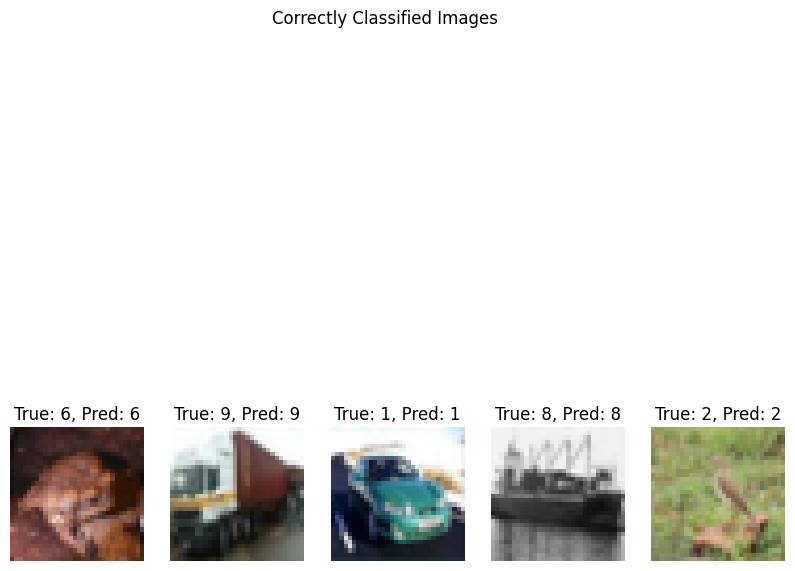

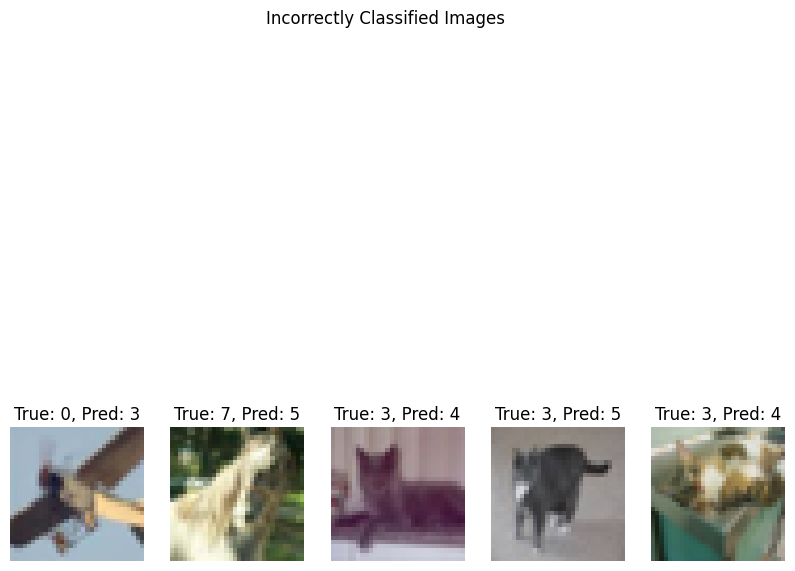

In [ ]:
# Plotting some correctly and incorrectly classified images from CNN model
# Identify correctly and incorrectly classified indices
correct_indices = np.where(y_pred_classes == y_true)[0]
incorrect_indices = np.where(y_pred_classes != y_true)[0]

# Function to plot images
def plot_images(indices, title, n_images=5):
    plt.figure(figsize=(10, 10))
    for i, index in enumerate(indices[:n_images]):
        plt.subplot(1, n_images, i + 1)
        plt.imshow(X_test[index])
        plt.title(f"True: {y_true[index]}, Pred: {y_pred_classes[index]}")
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Plot some correctly classified images
plot_images(correct_indices, title="Correctly Classified Images")

# Plot some incorrectly classified images
plot_images(incorrect_indices, title="Incorrectly Classified Images")

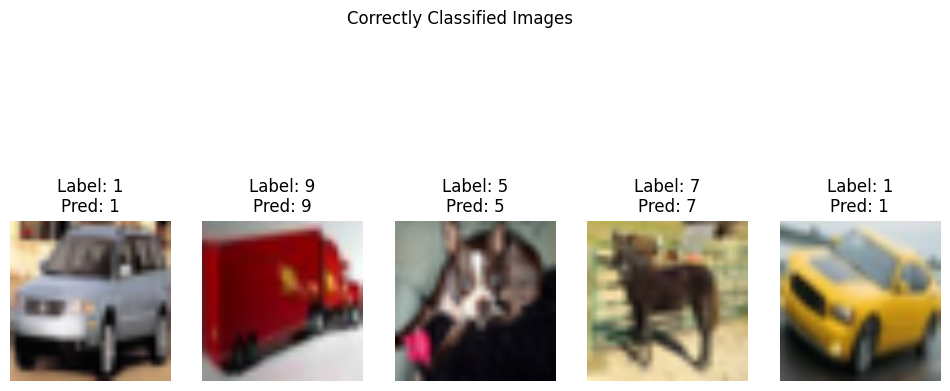

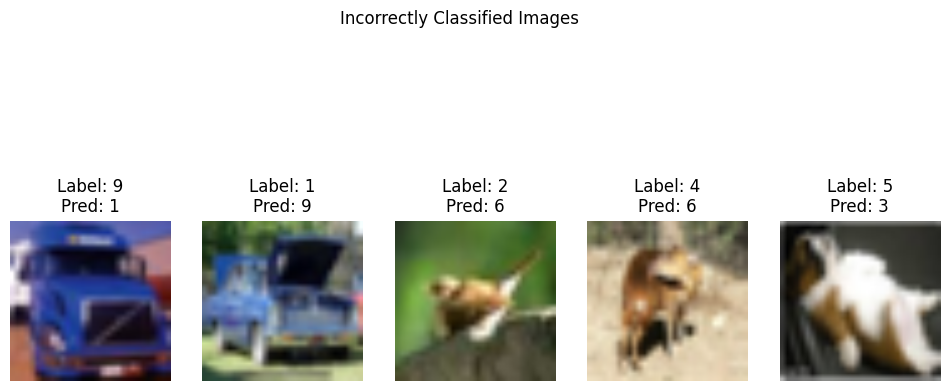

In [ ]:
# Plotting some correctly and incorrectly classified images from Vision Transformer model
import torch
import matplotlib.pyplot as plt
import numpy as np

# Set model to evaluation mode
model_hg.eval()

# Lists to store correctly and incorrectly classified images
correct_images = []
correct_labels = []
correct_preds = []

incorrect_images = []
incorrect_labels = []
incorrect_preds = []

# Disable gradient calculation for evaluation
with torch.no_grad():
    for val_images, val_labels in val_loader:
        val_images = val_images.to(device)
        val_labels = val_labels.to(device)

        # Get model predictions
        outputs = model_hg(val_images)
        _, predicted = torch.max(outputs.logits, 1)

        # Store correct and incorrect classifications
        for i in range(len(val_labels)):
            if predicted[i] == val_labels[i]:
                correct_images.append(val_images[i].cpu())
                correct_labels.append(val_labels[i].cpu())
                correct_preds.append(predicted[i].cpu())
            else:
                incorrect_images.append(val_images[i].cpu())
                incorrect_labels.append(val_labels[i].cpu())
                incorrect_preds.append(predicted[i].cpu())

# Function to plot images
def plot_images(images, labels, preds, title, n=5):
    plt.figure(figsize=(12, 6))
    for i in range(n):
        plt.subplot(1, n, i+1)
        image = images[i].permute(1, 2, 0).numpy()
        image = (image - image.min()) / (image.max() - image.min())  # Scale image to [0, 1]
        plt.imshow(image)
        plt.title(f"Label: {labels[i].item()}\nPred: {preds[i].item()}")
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Plot some correctly classified images
plot_images(correct_images, correct_labels, correct_preds, "Correctly Classified Images", n=5)

# Plot some incorrectly classified images
plot_images(incorrect_images, incorrect_labels, incorrect_preds, "Incorrectly Classified Images", n=5)


###g.

i.
Model CNN:

Class 0: Precision of 0.80, Recall of 0.61, F1-score of 0.69. This class has relatively high precision but lower recall, meaning that while predictions for this class are accurate, many actual instances are missed.
Class 1: Precision of 0.88, Recall of 0.78, F1-score of 0.83. This class has high precision and recall, indicating strong performance.
Class 2: Precision of 0.63, Recall of 0.55, F1-score of 0.59. This class has moderate performance with a lower recall.
Class 3: Precision of 0.62, Recall of 0.48, F1-score of 0.54. This class has lower recall, indicating it is harder for the model to detect this class.
Class 4: Precision of 0.58, Recall of 0.78, F1-score of 0.66. This class has high recall but lower precision, meaning many instances are detected but with some false positives.
Class 5: Precision of 0.59, Recall of 0.60, F1-score of 0.60. This class has balanced but modest performance.
Class 6: Precision of 0.71, Recall of 0.80, F1-score of 0.75. This class performs well with high recall.
Class 7: Precision of 0.78, Recall of 0.74, F1-score of 0.76. This class also shows strong performance with high precision and recall.
Class 8: Precision of 0.73, Recall of 0.90, F1-score of 0.80. This class has the highest recall and good precision, indicating it is well-predicted.
Class 9: Precision of 0.80, Recall of 0.81, F1-score of 0.81. This class has balanced high performance.

Huggingface Model:

High Accuracy: The model achieves a high accuracy of 96.87% on the test set, demonstrating strong generalization.
Class-wise Performance: Most classes have very high precision and recall, suggesting that the model effectively identifies and distinguishes between classes.
Balanced Performance: The macro and weighted averages show balanced performance across different classes, with no significant weaknesses.

ii. In CNN overall accuracy is good, given the quality of the images. Some classes have low accuracy like 4 and 5 (deer, dog) and some have very high like 1 (automobile). The model performs poorly on animal classification.

iii. I spent a long time on this problem, I was not getting good results with Hugingface model in the beginning, I was able to fine-tune it for a lower resolution images in the end.

iv. For the huggingface model, it was confusing automobiles with truck which can be seen from plotting the correct and incorrect images. It is easy to confuse those two and some images of automobile were not very clear or had doors or trunks open

v. For CNN model, the model could be improved, especially in classes with lower recall or precision. The huggingface model does not need futher improvement.

